In [1]:
# code for automatically reloading changes from modules (used for testing)
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from TQ_cycle_benchmarking_iceberg import CB_Experiment
from selene_sim import DepolarizingErrorModel, Stim
# from selene_custom_error_model import (
#     BasicErrorModel,
#     OneQubitErrorRates,
#     TwoQubitErrorRates,
# )

In [3]:
# select parameters and build experiment

qubits = [(0,1), (2,3), (4,5), (6,7)]
seq_lengths = [4, 20]
filename = 'exp_CB_example.p'

exp = CB_Experiment(qubits, seq_lengths, filename=filename)
exp.add_settings()

Having setup our cycle benchmarking experiment, we can now either simulate using a local simulator or submit to a hardware or emulator backend.

### Run local simulation using Selene

In [4]:
# setup error model

# p_2q = TwoQubitErrorRates(
#     ix=0.0001,
#     iy=0.0001,
#     iz=0.0002,
#     xi=0.0001,
#     xz=0.0001,
#     yi=0.0001,
#     yz=0.0001,
#     zi=0.0002,
#     zx=0.0001,
#     zy=0.0001,
#     zz=0.00005,
#     # anything you don't set is 0 by default
# )

error_model = DepolarizingErrorModel(
    random_seed=1234,
    # single qubit gate error rate
    p_1q=3e-5,
    # two qubit gate error rate
    p_2q=1e-3,
    # set state preparation and measurement error rates to 0
    p_meas=1e-3,
    p_init=0,
)


In [6]:
# simulate experiment

shots = 1000
simulator = Stim()

exp.sim(shots, error_model=error_model, simulator=simulator)

Simulating ...
1/16 circuits complete
2/16 circuits complete
3/16 circuits complete
4/16 circuits complete
5/16 circuits complete
6/16 circuits complete
7/16 circuits complete
8/16 circuits complete
9/16 circuits complete
10/16 circuits complete
11/16 circuits complete
12/16 circuits complete
13/16 circuits complete
14/16 circuits complete
15/16 circuits complete
16/16 circuits complete


### Submit to Quantinuum Hardware or Emulator backend using Nexus

In [ ]:
# Choose domain and login to Nexus

import qnexus
from qnexus.config import CONFIG

CONFIG.domain = "qa.myqos.com"
qnexus.login()

🌐 Browser log in initiated.


╭────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                        │
│         Confirm that the browser shows the following code and click 'allow device':    │
│                                                                                        │
│                                      gwkRhM                                            │
│                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────╯

Browser didn't open automatically? Use this link: https://qa.myqos.com/auth/device/browser?otp=gwkRhMDWxgJ0dttAXob3pknSbIffzATSKLV_vZf7Jl0GyM3yqaP7lQKJ8Y1NykRLjVwPd73lVhIyOAkN8UBEjA
✅ Successfully logged in as karl.mayer@quantinuum.com using the browser.


In [ ]:
# choose nexus project and setup quantinuum backend config

project = qnexus.projects.get_or_create(name='CB-example-project')
qnexus.context.set_active_project(project)

backend_config = qnexus.QuantinuumConfig(device_name='Helios-1E')

In [ ]:
# submit experiment. Returns a qnexus ExecuteJobRef

shots = 100

execute_job_ref = exp.submit(shots, backend_config)

In [ ]:
# inspect status of the execution job

qnexus.jobs.status(execute_job_ref)

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2025, 5, 23, 2, 28, 35, 493394, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2025, 5, 22, 19, 34, 28, 277975, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2025, 5, 22, 19, 35, 5, 31120, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)

In [ ]:
# retrieve results

exp.retrieve(execute_job_ref)

### Analyze experiment results

/Users/charles.baldwin/Documents/GitHub/circuit-benchmarks-guppy/TQ_cycle_benchmarking_iceberg.py:479: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, x, y, p0=[0.9, 0.9], bounds=([0,0], [1,1]))
/Users/charles.baldwin/Documents/GitHub/circuit-benchmarks-guppy/TQ_cycle_benchmarking_iceberg.py:603: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, x, y, p0=[0.9, 0.9], bounds=([0,0], [1,1]))


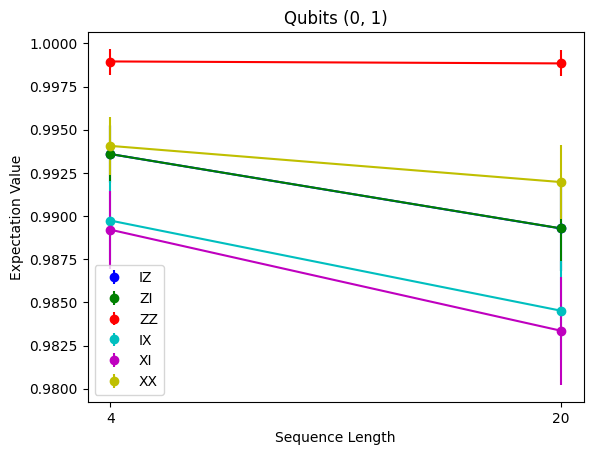

/Users/charles.baldwin/Documents/GitHub/circuit-benchmarks-guppy/TQ_cycle_benchmarking_iceberg.py:603: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, x, y, p0=[0.9, 0.9], bounds=([0,0], [1,1]))


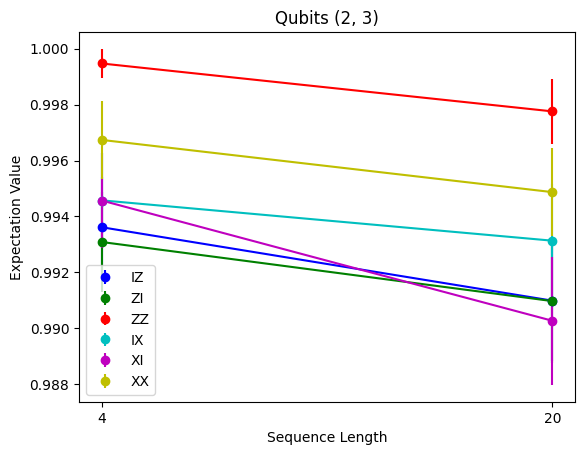

/Users/charles.baldwin/Documents/GitHub/circuit-benchmarks-guppy/TQ_cycle_benchmarking_iceberg.py:603: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, x, y, p0=[0.9, 0.9], bounds=([0,0], [1,1]))


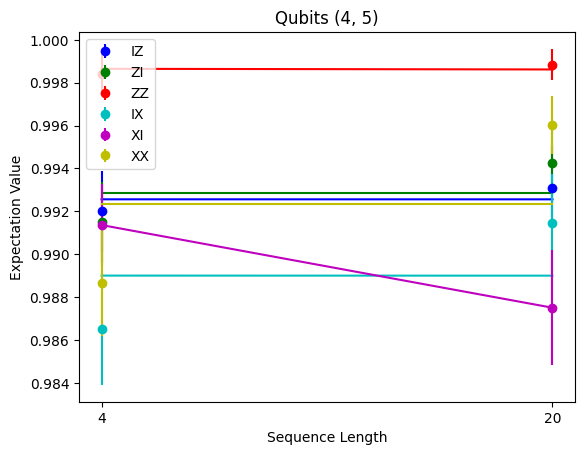

/Users/charles.baldwin/Documents/GitHub/circuit-benchmarks-guppy/TQ_cycle_benchmarking_iceberg.py:603: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, x, y, p0=[0.9, 0.9], bounds=([0,0], [1,1]))


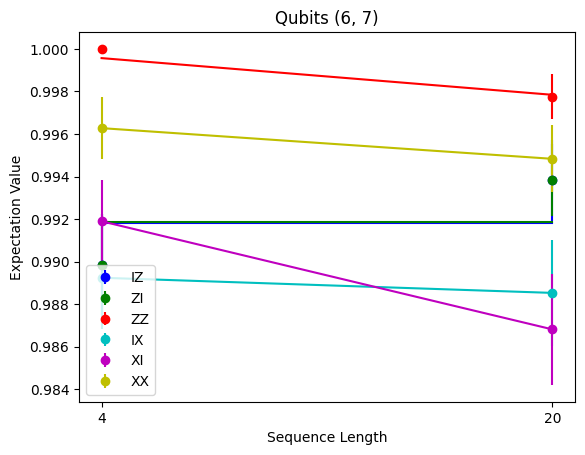

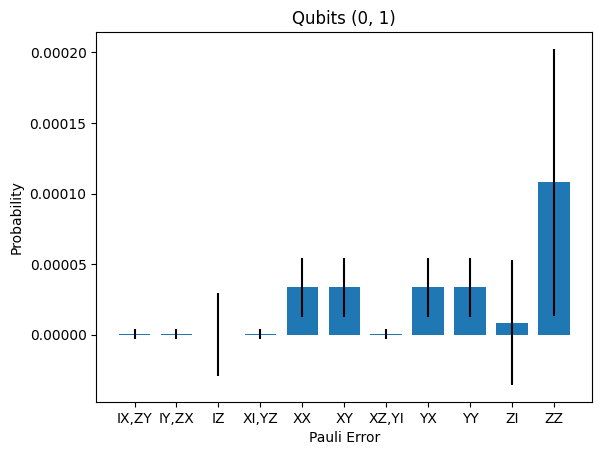

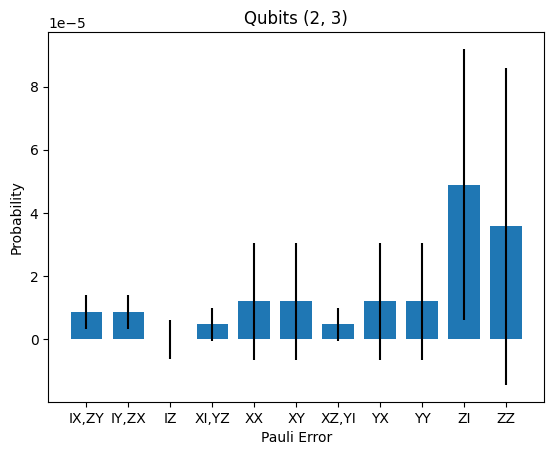

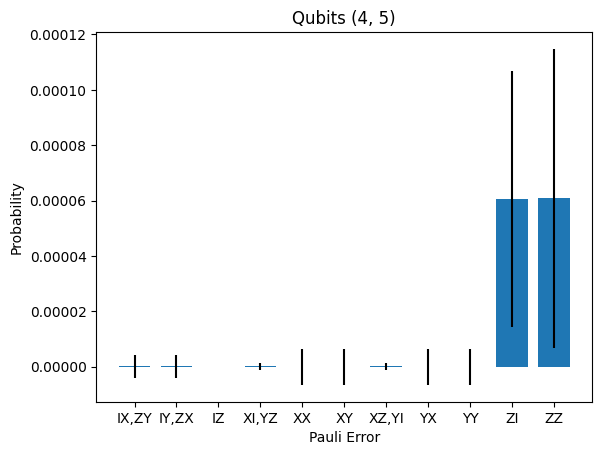

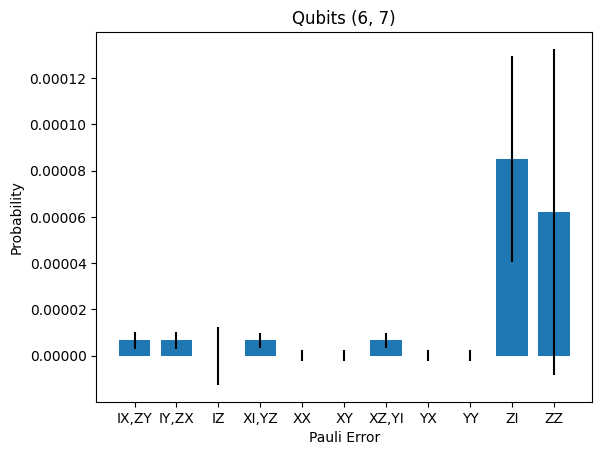

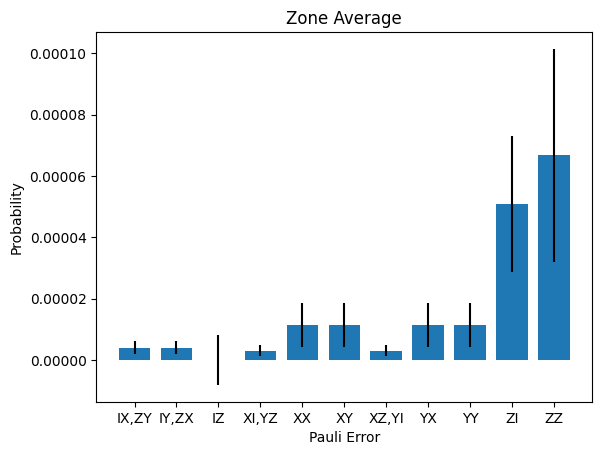

Average Fidelity
--------------------------
(0, 1): 0.9998 +/- 0.0001
(2, 3): 0.99985 +/- 7e-05
(4, 5): 0.9999 +/- 8e-05
(6, 7): 0.99984 +/- 8e-05

Zone Average:
0.99985 +/- 4e-05


In [9]:
exp.analyze_results(plot_orbits=True)

In [ ]:
# print estimated Pauli errors

P_probs = exp.mean_Pauli_probs
P_stds = exp.mean_Pauli_stds

for P in P_probs:
    print(f'{P}: {round(P_probs[P], 6)} +/- {round(P_stds[P], 6)}')

IX: 0.000102 +/- 2e-06
IY: 0.000102 +/- 2e-06
IZ: 0.000192 +/- 9e-06
XI: 9.5e-05 +/- 2e-06
XX: 0.0 +/- 0.0
XY: 0.0 +/- 0.0
XZ: 9.5e-05 +/- 2e-06
YI: 9.5e-05 +/- 2e-06
YX: 0.0 +/- 0.0
YY: 0.0 +/- 0.0
YZ: 9.5e-05 +/- 2e-06
ZI: 0.000248 +/- 1e-05
ZX: 0.000102 +/- 2e-06
ZY: 0.000102 +/- 2e-06
ZZ: 4.4e-05 +/- 7e-06


In [ ]:
# save experiment object to working directory

exp.save()